# Introduction to Inference in Pyro

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

In [4]:
pyro.set_rng_seed(101)

In [5]:
def scale(guess):
    weight = pyro.sample('weight', dist.Normal(guess, 1.0))
    return pyro.sample('measurement', dist.Normal(weight, 0.75))

In [6]:
scale(10.)

tensor(7.9981)

We are working working toward P(weight|guess, measurement=9.5) 

In [7]:
conditioned_scale = pyro.condition(scale, data={'measurement': 9.5})

In [8]:
conditioned_scale(10.)

9.5

In [9]:
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={'measurement': measurement})(guess)

In [10]:
deferred_conditioned_scale(9.5, 10.)

9.5

In some cases it might be more convenient to pass observations directly to individual `pyro.sample` statements instead of 
using `pyro.condition`. The optional `obs` keyword argument is reserved by `pyro.sample` for that purpose.

In [11]:
def scale_obs(guess): # equivalent to conditioned_scale above
    weight = pyro.sample('weight', dist.Normal(guess, 1.))
    # here we condition on measurement == 9.5
    return pyro.sample('measurement', dist.Normal(weight, 0.75), obs=9.5)

In [12]:
scale_obs(10.)

/home/ben/.local/share/virtualenvs/causalML-xeA8SeKA/lib/python3.8/site-packages/pyro/primitives.py:85: RuntimeWarning: trying to observe a value outside of inference at measurement
  warnings.warn("trying to observe a value outside of inference at " + name,


9.5

Finally, in addition to `pyro.condition` for incorporating observations, Pyro also contains `pyro.do`,
and implementation of Pearl's `do`-operator used for causal inference with an identical interfact to `pyro.condition`.
`condition` and `do` can be mixed and composed freely, making Pyro a powerful tool for model-based causal inference.

# Flexible Approximate Inference With Guide Functions

Lets return to `conditioned_scale`. Now that we have conditioned on an observation of `measurement`, we can use Pyro's approximate
inference algorithms to estimate the distribution over `weight` given `guess` and `measurement == data`

Inference algorithms in Pyro, such as `pyro.infer.SVI`, allow us to use arbitrary stochastic functions, which we will call _guide functions_ or _guides_, as approximate posterior distributions. Guide functions must satisfy these two criteria to be valid approximations for a particular model: 1. all unobserved (i.e. not conditioned) sample statements that appear in the model appear in the guide. 2. the guide has the same input signature as the model (i.e. takes the same arguments)

Guide functions can serve as programmable, data-dependent proposal distributions for importance sampling, rejection sampling, sequential Monte Carlo, MCMC, and independent Metropolis-Hastings, and as variational distributions or inference networks for stochastic variational inference. Currently, importance sampling, MCMC, and stochastic variational inference are implemented in Pyro, and we plan to add other algorithms in the future.

Although the precise meaning of the guide is different across different inference algorithms, the guide function should generally be chosen so that, in principle, it is flexible enough to closely approximate the distribution over all unobserved `sample` statements in the model.

In the case of `scale`, it turns out that the true posterior distribution over `weight` given `guess` and `measurement` is actually Normal(9.14, 0.6). As the model is quite simple, we are able to determine our posterior distribution of interest analytically.

In [13]:
def perfect_guide(guess):
    loc = (0.75**2 * guess + 9.5) / (1. + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample('weight', dist.Normal(loc, scale))

In [14]:
perfect_guide(9.5)

tensor(9.8620)

# Parameterized Stochastic Functions and Variational Inference

Although we could write out the exact posterior distribution for `scale`, in general it is intractable to specify a guide that is a good approximation to the posterior distribution of an arbitrary conditioned stochastic function. In fact, stochastic function for which we can determine the true posterior exactly are the exception rather than the rule. For example, even a version of our `scale` example with a nonlinear function in the middle may be intractable.

```python
def intractable_scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    return pyro.sample('measurement', dist.Normal(some_nonlinear_function(weight), 0.75))
```

What we can do instead is use the top-level function `pyro.param` to specify a _family_ of guides indexed by named parameters, and search for the member of that famiily that is the best approximation according to some loss function. This approach to approximate posterior inference is called _variational inference_.

`pyro.param` is a frontend for Pyro's key-value _parameter store_. Like `pyro.sample`, `pyro.param` is always called with a name as its first argument. The first time `pyro.param` is called with a particular name, it stores its argument in the paramter store and then returns that value. After than, when it is called with that name, it returns the value from the parameter store regardless of any other arguments. It is similar to `simple_param_store.setdefault` here, but with some additional tracking and management functionality.

```python
simple_param_store = {}
a = simple_param_store.setdefault('a', torch.randn(1))
```

For example, we can paramterize `a` and `b`  in `scale_posterior_guide` instead of specifying them by hand:

In [15]:
def scale_parameterized_guide(guess):
    a = pyro.param('a', torch.tensor(guess))
    b = pyro.param('b', torch.tensor(1.))
    return pyro.sample('weight', dist.Normal(a, torch.abs(b)))

In [16]:
scale_parameterized_guide(9.5)

tensor(9.2480, grad_fn=<AddBackward0>)

As an aside, note that in `scale_parameterized_guide`, we had to apply `torch.abs` to parameter `b`, because the standard deviation of a normal distribution has to be positive; similar restrictions apply to parameters of many other distributions. The PyTorch distribution library which Pyro is built on, includes a constraints module for enforcing such restrictions, and applying constriants to Pyro parameters is as easy as passing the relevant `constraint` object to `pyro.param`:

In [17]:
from torch.distributions import constraints
def scale_parameterized_guide_constraint(guess):
    a = pyro.param('a', torch.tensor(guess))
    b = pyro.param('b', torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample('weight', dist.Normal(a, b)) # no more abs

Pyro is built to enable _stochastic variational inference_, a powerful and widely applicable class of variational inference algorithms with three key characteristics:
1. Parameters are always real-valued tensors.
2. We compute Monte Carlo estimates of a loss function from samples of execution histories of the model and guide.
3. We used stochastic gradient descent to search for the optimal parameters.

Combining stochastic gradient descent with PyTorch's GPU-accelerated tensor math and automatic differentiation allows us to scale variational inference to very high-dimensional parameter spaces and massive datasets.

Pyro's SVI functionality is described in detail in the SVI tutorial. Here is a very simple example applying it to `scale`.

a = 9.105514526367188
b = 0.6252198219299316


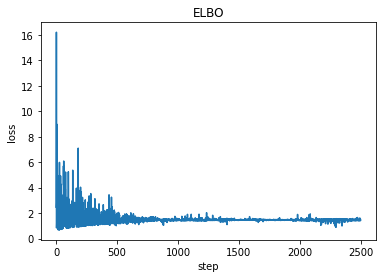

In [21]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned_scale,
    guide=scale_parameterized_guide,
    optim=pyro.optim.SGD({'lr':0.001, 'momentum': 0.1}),
    loss = pyro.infer.Trace_ELBO()
)
losses, a, b = [], [], []
num_steps = 2_500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param('a').item())
    b.append(pyro.param('b').item())
plt.plot(losses)
plt.title('ELBO')
plt.xlabel('step')
plt.ylabel('loss')
print('a = {}'.format(pyro.param('a').item()))
print('b = {}'.format(pyro.param('b').item()))

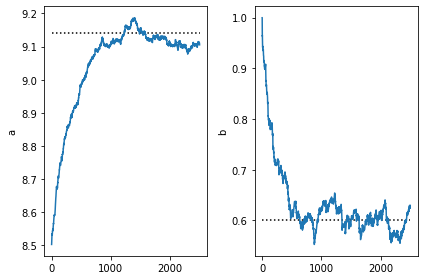

In [22]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()
